# Notebook 42: Building the (P,q,e) sampling table

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import pandas as pd
from time import time

In [2]:
import sys
sys.path.append('..')
from src.zams import EccentricityDistribution, MassRatioDistribution, CompanionFrequencyDistribution, ZAMSSystemGenerator
from src.utils import sample_histogram

In [3]:
def salpeter(x):
    return -2.3*x

In [4]:
logm1min = np.log10(0.8)
logm1max = np.log10(150)
logpmin = 0.2
logpmax = 8
qmin = 0.1
qmax = 1
emin = 0
emax = 1

In [5]:
logm1n = 200
logpn = 100
qn = 100
en = 10

#### Table creation

In [6]:
map_logm1s = np.empty(logm1n, np.float16)
map_logps = np.empty((logm1n, logpn), np.float16)

In [7]:
#### map_m1s
np.random.seed(42)

mapm1s_logms = np.linspace(logm1min, logm1max, 10000)

mapm1s_salpeter = np.array([salpeter(m) for m in np.linspace(logm1min, logm1max, 10000)])
mapm1s_salpeter += mapm1s_salpeter.min()
mapm1s_salpeter /= mapm1s_salpeter.sum()

mapm1s_salpeter_sample = np.random.choice(mapm1s_logms, 1000, p=mapm1s_salpeter)

map_logm1s = np.quantile(mapm1s_salpeter_sample, np.linspace(0, 1, logm1n))

In [8]:
from concurrent.futures import ProcessPoolExecutor, as_completed

In [9]:
canonical = True
extrapolate_logp_canon = True

In [10]:
def get_logps(m1_i_logm1):
    m1_i, logm1 = m1_i_logm1
    m1 = 10**logm1
    q_distr = MassRatioDistribution(canonical=canonical)
    freq_distr = CompanionFrequencyDistribution(q_distr, m1, canonical, extrapolate_logp_canon)

    maplogps_freqdistr = np.array([freq_distr.companion_frequency_q01(logp) for logp in maplogps_logps])
    maplogps_freqdistr /= maplogps_freqdistr.sum()

    maplogps_logp_sample = np.random.choice(maplogps_logps, 1000, p=maplogps_freqdistr)

    return m1_i, np.quantile(maplogps_logp_sample, np.linspace(0, 1, logpn))

In [11]:
np.random.seed(42)

maplogps_logps = np.linspace(logpmin, logpmax, 10000)

with ProcessPoolExecutor(8) as executor:
    for i_result in executor.map(get_logps, list(enumerate(map_logm1s))):
        m1_i, result = i_result
        map_logps[m1_i] = result

In [12]:
if canonical:
    map_file = tb.open_file('../Data/canonical_mp_qe_table.h5', mode='w', title='M,P, to q,e table')
else:
    map_file = tb.open_file('../Data/correlated_mp_qe_table.h5', mode='w', title='M,P, to q,e table')


In [13]:
class QETable(tb.IsDescription):
    e = tb.Float32Col()
    q = tb.Float32Col()

In [14]:
import warnings
warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

In [15]:
total_time = 0

mapqs_qs = np.linspace(0.1, 1, 10000)
mapes_es = np.linspace(0, 1, 1000)[:-1]

map_qdistr = MassRatioDistribution(canonical)
map_edistr = EccentricityDistribution(canonical)
for m1_i, logm1 in enumerate(map_logm1s):
    start_time = time()
    m1 = 10**logm1
    map_group = map_file.create_group('/', str(m1_i), f'{m1:.8f}')
    for logp_i, logp in enumerate(map_logps[m1_i]):
        map_qdistr.set_parameters(m1, logp)
        map_edistr.set_parameters(m1, logp)
        
        mapqs_qprobs = np.array([map_qdistr.prob(q) for q in mapqs_qs])
        mapqs_qprobs /= mapqs_qprobs.sum()
        np.random.seed(42)
        mapqs_q_sample = np.random.choice(mapqs_qs, 1000, p=mapqs_qprobs)
        
        if logp > 2:
            mapes_eprobs = np.array([map_edistr.prob(e) for e in mapes_es])
            mapes_eprobs /= mapes_eprobs.sum()
            np.random.seed(42)
            mapes_e_sample = np.random.choice(mapes_es, 100, p=mapes_eprobs)
        else:
            mapes_e_sample = np.tile(0, 100)
        
        map_qs = np.quantile(mapqs_q_sample, np.linspace(0, 1, qn))
        map_es = np.quantile(mapes_e_sample, np.linspace(0, 1, en))
        
        map_lines = np.array(np.meshgrid(map_es, map_qs)).T.reshape(-1, 2)
        map_table = map_file.create_table(map_group, str(logp_i), QETable, f'{logp:.8}')
        map_row = map_table.row
        
        for line in map_lines:
            map_row['e'] = line[0]
            map_row['q'] = line[1]
            map_row.append()
        map_table.flush()
    end_time = time()
    total_time += end_time - start_time
    print(f'Done with m1 = {m1} ({m1_i}/{logm1n})in {end_time-start_time} s.')
print(f'Done. Total elapsed time: {total_time}')        

Done with m1 = 0.8302901963379324 (0/200)in 39.0901985168457 s.
Done with m1 = 0.8726392043337586 (1/200)in 41.0889356136322 s.
Done with m1 = 0.888644776510791 (2/200)in 41.14164996147156 s.
Done with m1 = 0.9239132366575831 (3/200)in 42.19051933288574 s.
Done with m1 = 0.9435258519470321 (4/200)in 42.85571360588074 s.
Done with m1 = 0.9781485411863469 (5/200)in 42.138734102249146 s.
Done with m1 = 0.9925455168662293 (6/200)in 40.605531454086304 s.
Done with m1 = 1.042501083003896 (7/200)in 41.24713325500488 s.
Done with m1 = 1.0691912828904755 (8/200)in 39.406152963638306 s.
Done with m1 = 1.1049467207337846 (9/200)in 39.77795219421387 s.
Done with m1 = 1.1411772552406338 (10/200)in 42.263606548309326 s.
Done with m1 = 1.1937556460708512 (11/200)in 39.14513802528381 s.
Done with m1 = 1.2398868868944504 (12/200)in 41.4040789604187 s.
Done with m1 = 1.3088331328046858 (13/200)in 40.51467561721802 s.
Done with m1 = 1.3650152599356045 (14/200)in 39.37463140487671 s.
Done with m1 = 1.4102

In [16]:
map_file.close()

## Checking the table

In [8]:
#map_file = tb.open_file('../Data/mp_qe_table.h5', mode='r')
map_file = tb.open_file('../Data/canonical_mp_qe_table.h5', mode='r')

In [9]:
len(list(map_file.root._v_groups))

200

In [10]:
m1s = []
for group in map_file.root._v_groups:
    m1 = map_file.root[group]
    m1s.append(m1._v_title)

In [11]:
np.unique(m1s).size

200

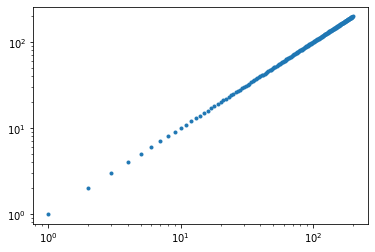

In [12]:
plt.plot(m1s,'.')
plt.xscale('log')
plt.yscale('log')

In [43]:
from src.zams import ZAMSSystemGenerator
from src.constants import BINARIES_CANONICAL_TABLE_PATH, BINARIES_CORRELATED_TABLE_PATH
from src.utils import valley_minimum

In [59]:
gen = ZAMSSystemGenerator(BINARIES_CANONICAL_TABLE_PATH, np.linspace(0.8, 150, int(1e5)))

In [60]:
gen.setup_sampler()

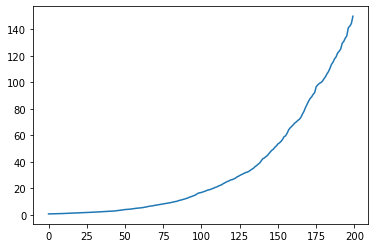

In [61]:
plt.plot(gen.m1_options)

In [62]:
m1 = 10
print(valley_minimum(np.abs(gen.m1_options - m1), np.arange(0, len(gen.m1_options), 1)))
print(gen.m1_options[valley_minimum(np.abs(gen.m1_options - m1), np.arange(0, len(gen.m1_options), 1))[0]])
gen.m1_array = m1
print(gen._get_m1())

(82, 0.10436344)
9.895637
(9.895637, /82 (Group) '9.89563628'
  children := ['0' (Table), '1' (Table), '10' (Table), '11' (Table), '12' (Table), '13' (Table), '14' (Table), '15' (Table), '16' (Table), '17' (Table), '18' (Table), '19' (Table), '2' (Table), '20' (Table), '21' (Table), '22' (Table), '23' (Table), '24' (Table), '25' (Table), '26' (Table), '27' (Table), '28' (Table), '29' (Table), '3' (Table), '30' (Table), '31' (Table), '32' (Table), '33' (Table), '34' (Table), '35' (Table), '36' (Table), '37' (Table), '38' (Table), '39' (Table), '4' (Table), '40' (Table), '41' (Table), '42' (Table), '43' (Table), '44' (Table), '45' (Table), '46' (Table), '47' (Table), '48' (Table), '49' (Table), '5' (Table), '50' (Table), '51' (Table), '52' (Table), '53' (Table), '54' (Table), '55' (Table), '56' (Table), '57' (Table), '58' (Table), '59' (Table), '6' (Table), '60' (Table), '61' (Table), '62' (Table), '63' (Table), '64' (Table), '65' (Table), '66' (Table), '67' (Table), '68' (Table), '69' (

In [63]:
test_m1s = np.linspace(0.8, 150, 1000)

In [64]:
closest_m1s = []
for m1 in test_m1s:
    gen.m1_array = m1
    closest_m1s.append(gen._get_m1()[0])

Text(0, 0.5, 'Closest table m1')

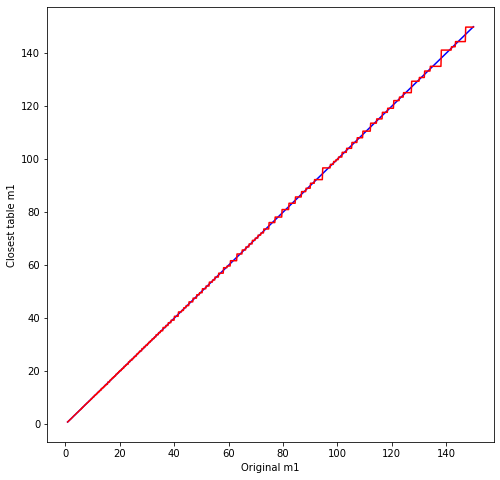

In [65]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(test_m1s, test_m1s, 'b-')
ax.plot(test_m1s, closest_m1s, 'r-')

ax.set_xlabel('Original m1')
ax.set_ylabel('Closest table m1')

In [68]:
eccs = []
for i in range(200):
    gen.open_m1group(i)
    for j in range(100):
        jstr = str(j)
        logp_table = gen.m1group[jstr]
        for k in range(1000):
            ecc = logp_table[k]['e']
            eccs.append(ecc)

In [73]:
eccs = np.array(eccs)

In [74]:
np.unique(eccs, return_counts=True)

(array([0.], dtype=float32), array([20000000]))

In [75]:
qs = []
for i in range(200):
    gen.open_m1group(i)
    for j in range(100):
        jstr = str(j)
        logp_table = gen.m1group[jstr]
        for k in range(1000):
            q = logp_table[k]['q']
            qs.append(q)

In [76]:
qs = np.array(qs)

In [77]:
np.unique(qs, return_counts=True)

(array([0.10414042, 0.11180755, 0.11876278, 0.12471975, 0.13328697,
        0.14110957, 0.15126422, 0.16306359, 0.17039523, 0.17677768,
        0.18420751, 0.19153915, 0.20190655, 0.20641519, 0.21469602,
        0.22418788, 0.22940022, 0.23847476, 0.24602734, 0.2549137 ,
        0.26011783, 0.2663121 , 0.27632764, 0.28905162, 0.3024548 ,
        0.31398413, 0.32098848, 0.3280828 , 0.3415187 , 0.3494313 ,
        0.3549382 , 0.36365274, 0.3781769 , 0.38865885, 0.39577776,
        0.4054251 , 0.4140496 , 0.42272317, 0.4309631 , 0.43727192,
        0.4461419 , 0.45602652, 0.46699944, 0.47635219, 0.48478848,
        0.49531135, 0.50733167, 0.51662713, 0.52735454, 0.5438344 ,
        0.55218065, 0.5600196 , 0.5677768 , 0.57294   , 0.58334833,
        0.5920792 , 0.60001636, 0.61176664, 0.61958104, 0.62782913,
        0.6351117 , 0.64412075, 0.65159154, 0.66037965, 0.6677522 ,
        0.6727027 , 0.6809181 , 0.6931511 , 0.7013583 , 0.71505606,
        0.7264054 , 0.733467  , 0.7458964 , 0.75

In [78]:
df = pd.DataFrame([[1, 2, 3], [1, 3, 5], [1, 2, 6]], columns=['A', 'B', 'C'])

In [91]:
df.iloc[[0]].A.nunique()

1

In [85]:
for i in range(100):
    if i == 56:
        if 1:
            continue
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [67]:
gen.open_m1group(23)

In [53]:
logp_table = gen.m1group['55']

In [56]:
type(logp_table[3]['q'])

numpy.float32

In [58]:
gen.close_binaries_table()

In [57]:
map_file.close()

NameError: name 'map_file' is not defined